# The Robobatter-9000 Strikes Out!
## Using Machine Learning to Classify and Predict MLB Pitches

### Introduction
The year is 2123. Self-learning robots are now common. One robot in question is officially named the "ROBOBATTER-9000", but goes by Bob after realizing that there is a critical lack of sports players who go by Bob. In this technologically near land, Bob wants nothing more than to take over the world... of baseball. 

Because Bob is a specialized robot, he has mastered his swing to be mechanically and has advanced vision and telemetry can track almost any pitch. If he can connect with the ball, the ball will be crushed for a home run. However, a design flaw has taken away almost all of the pre-pitch time away to set up the mechanics of the swing and the telemetry. Because of that, Bob will have to decide pre-pitch what type of pitch will be thrown. If it is a fastball, he can easily track it and hit it out of the park. Otherwise, he will pass on the pitch if not a fastball, and will wait until another fastball is thrown to take another chance at swinging. This leaves Bob with 2 main problems:
1) Can he correctly identify and classify pitches based on who is throwing them?
2) Can he correctly predict what type of pitch is coming next?

## Part 1: Pitch Classification

### The Dataset
The main dataset used will be the pybaseball package, which scrapes data from Baseball Reference, MLB Statcast, and Fangraphs. The primary utilization will be the Statcast portion of the dataset, used for its detailed pitch breakdowns, such as pitch x, y, and z velocition and accceleration.

In [ ]:
!pip install pybaseball

import pybaseball as pyb
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

import warnings
warnings.filterwarnings('ignore')

Pybaseball has a statcast function, which will gather every single pitch thrown in the 2022 MLB season, which is over 750,000 pitches. 

In [2]:
pitches = pyb.statcast(start_dt='2022-03-22', end_dt='2022-10-05')
print("Dataset has {0} pitches".format(len(pitches)))
print(pitches.shape)

This is a large query, it may take a moment to complete


100%|██████████| 198/198 [01:59<00:00,  1.66it/s]


Dataset has 750075 pitches
(750075, 92)


First we will begin to clean up the data. The first part of cleaning up the data will be identifying and getting rid of null items in the dataset.

In [8]:
pitches.isnull().sum()

pitch_type               19901
game_date                    0
release_speed            19666
release_pos_x            19649
release_pos_z            19649
                         ...  
if_fielding_alignment    30174
of_fielding_alignment    30174
spin_axis                22751
delta_home_win_exp           0
delta_run_exp            41582
Length: 92, dtype: int64

In [9]:
pitches.dropna(axis="columns", how="all", inplace=True)
pitches.shape

(750075, 84)

The next step in cleaning up the dataset is indentifying what types of pitches we want to include. Because Statcast identifies pitches like pitchouts (when a pitcher throws the ball to the catcher so that the catcher can throw out a baserunner that is stealing a base) or intentional balls (when a pitcher intentionally throws a ball to eventually walk the batter), we need to filter out to only include actual pitches thrown to better categorize the dataset.

In [10]:
pitches.pitch_type.value_counts()

FF    242421
SL    132022
SI    113493
CH     82708
CU     57038
FC     52043
ST     19694
KC     15493
FS     10986
SV      2319
FA      1279
EP       494
CS       108
PO        40
KN        19
SC        17
Name: pitch_type, dtype: int64

In [11]:
pitches=pitches[pitches.pitch_type.isin(['CH', 'CU', 'EP', 'FC', 'FF', 'FO', 'FS', 'FT', 'GY', 'KC', 'KN', 'SC', 'SI', 'SL'])]
pitches.pitch_type.value_counts()

FF    242421
SL    132022
SI    113493
CH     82708
CU     57038
FC     52043
KC     15493
FS     10986
EP       494
KN        19
SC        17
Name: pitch_type, dtype: int64

To get a sense of what types of pitches are being thrown, we will take the first 500 pitches of the dataset and categorize them based on release speed and release spin rate. When graphed, we can get a sense of "clusters" of types of pitches. The fastballs shown (4-seam, sinker) are grouped very close together. Pretty much everything else can be classified as an "offspeed" pitch, and are each individually clustered on its own, not clustered with other types of offspeed pitches.

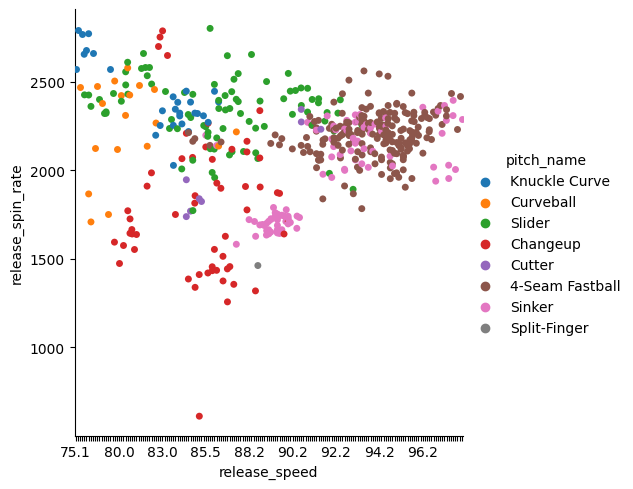

In [12]:
plot = sns.catplot(x='release_speed', y = 'release_spin_rate', hue = 'pitch_name', data=pitches[:500])

for ind, label in enumerate(plot.ax.get_xticklabels()):
    if ind % 20 == 0:
        label.set_visible(True)
    else:
        label.set_visible(False)

To help with the model later, we will create some extra variables, which will if there are runners on first, second, or third, and the total number of baserunners. For the pitch classification step next, the pitch will be either labeled as a fastball, breaking ball, or change. Breaking down just the fastballs, the dataset is roughly 60% fastballs and 40% offspeed (which includes both the breaking balls and changes).

In [13]:
pitches['runner_on_first'] = np.where(~pitches.on_1b.isnull(), 1, 0)
pitches['runner_on_second'] = np.where(~pitches.on_2b.isnull(), 1, 0)
pitches['runner_on_third'] = np.where(~pitches.on_3b.isnull(), 1, 0)
pitches['total_baserunners'] =  pitches['runner_on_first'] + pitches['runner_on_second'] + pitches['runner_on_third']
pitches['is_fastball'] = np.where(pitches.pitch_type.isin(['FF','SI','FT','FA','FS','FO','FC']), 1, 0)
pitches['is_breaking'] = np.where(pitches.pitch_type.isin(['CU', 'KC',  'KN', 'SC', 'SL']), 1, 0)
pitches['is_change'] =  np.where(pitches.pitch_type.isin(['CH', 'EP']), 1, 0)

pitches.is_fastball.value_counts(normalize=True)

1    0.592787
0    0.407213
Name: is_fastball, dtype: float64

Since we want this classification model to run on several different datasets, we can create a function that cleans, trains, and tests the model in one action. We will first only use a subset of the dataset, utilizing the pitch name, release spin and spin rate, as well as the x, y, and z pitch velocity and acceleration. We will also create "filters" for the fastball, breaking ball, and change pitches to see if the model can classify the pitches in grouped and non-grouped scenarios. We will use a decision tree as the primary machine learning model, and then compare the training and test score accuracies as well as the overall classification report of the decision tree.

In [14]:
def decision_tree(data,fastball,breaking,change):
    data = data.loc[:,['pitch_name',
                       'release_speed',
                       'release_spin_rate',
                       'vx0','vy0','vz0',
                       'ax','ay','az']]
    
    data = data.dropna()
    
    def fastball_pitch_filter(x):
        if x=='2-Seam Fastball' or x=='4-Seam Fastball' or x=='Sinker' or x=='Split-Finger' or x=='Cutter':
            return 'Fastball'
        return x
    
    def breaking_pitch_filter(x):
        if x=='Curveball' or x=='Slider' or x=='Screwball' or x=='Knuckle Curve' or x=='Knuckleball':
            return 'Breaking'
        return x
    def change_pitch_filter(x):
        if x=='Changeup' or x=='Eephus':
            return 'Change' 
        return x
    if fastball == True:
        data['pitch_name'] = data['pitch_name'].apply(fastball_pitch_filter)
    if breaking == True:
        data['pitch_name'] = data['pitch_name'].apply(breaking_pitch_filter)
    if change == True:
        data['pitch_name'] = data['pitch_name'].apply(change_pitch_filter)
    
    X = data.loc[:,['release_speed','vx0','vy0','vz0','ax','ay','az','release_spin_rate']]
    y = data.loc[:,['pitch_name']]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=8)
    
    dt_model = tree.DecisionTreeClassifier(max_depth=10, min_samples_split=50)
    
    dt_model.fit(X_train, y_train)
    
    predictions = dt_model.predict(X_train)
    print('Training Score Accuracy {0}'.format(accuracy_score(predictions, y_train)))
    
    predictions = dt_model.predict(X_test)
    print('Test Score Accuracy {0}'.format(accuracy_score(predictions, y_test)))
    
    print(classification_report(predictions, y_test))

The baseline tree, that is without grouping any pitch, as a training accuracy of 83.6% and test accuracy of 83%. This means that the model correctly labels around 83-84% of all of the 750,000 pitches thrown throughout the 2022 season. 

In [15]:
baseline_df = decision_tree(pitches, fastball=False, breaking=False, change=False)

Training Score Accuracy 0.8357235613776098
Test Score Accuracy 0.8308889362609252
                 precision    recall  f1-score   support

4-Seam Fastball       0.94      0.90      0.92     49908
       Changeup       0.89      0.85      0.87     17531
      Curveball       0.77      0.76      0.76     11627
         Cutter       0.54      0.64      0.59      8666
         Eephus       0.79      0.87      0.83        99
  Knuckle Curve       0.23      0.57      0.33      1261
    Knuckleball       0.17      1.00      0.29         1
         Sinker       0.82      0.86      0.84     21324
         Slider       0.86      0.77      0.81     29394
   Split-Finger       0.31      0.74      0.44       919

       accuracy                           0.83    140730
      macro avg       0.63      0.80      0.67    140730
   weighted avg       0.85      0.83      0.84    140730



Using just the fastball filter, the model's overall accuracy increases from around 83% to around 89%, with fastball recognition jumping to around 93%. The model does seem to struggle with certain offspeed pitches all around, particularly the knuckle and knuckle curveball, and screwball having an accuracy below 20%, with the knuckleball and the screwball having an accuracy of 0%. This might be due to the variance in how certain pitcher throw these types of pitches, but those will be broken down in the next two scenarios.

In [16]:
fastball_df = decision_tree(pitches, fastball=True, breaking=False, change=False)

Training Score Accuracy 0.8899642398435293
Test Score Accuracy 0.8858239181411213
               precision    recall  f1-score   support

     Changeup       0.89      0.86      0.88     17128
    Curveball       0.77      0.76      0.76     11511
       Eephus       0.87      0.85      0.86       112
     Fastball       0.93      0.95      0.94     81462
Knuckle Curve       0.24      0.60      0.34      1248
  Knuckleball       0.17      1.00      0.29         1
       Slider       0.86      0.78      0.82     29268

     accuracy                           0.89    140730
    macro avg       0.68      0.83      0.70    140730
 weighted avg       0.89      0.89      0.89    140730



Applying the breaking ball filter, the model can surprisingly classify those types of pitches with around 95% accuracy. This could mean that the model might just struggle with individual pitches, or that the broader categorization might mean that the model can label them more accurately.

In [17]:
breaking_df = decision_tree(pitches, fastball=False,  breaking=True,  change=False)

Training Score Accuracy 0.8805934089750354
Test Score Accuracy 0.8767711220066795
                 precision    recall  f1-score   support

4-Seam Fastball       0.94      0.91      0.92     49474
       Breaking       0.95      0.90      0.92     43136
       Changeup       0.89      0.85      0.87     17452
         Cutter       0.52      0.66      0.58      8119
         Eephus       0.70      0.88      0.78        86
         Sinker       0.82      0.86      0.84     21517
   Split-Finger       0.32      0.73      0.44       946

       accuracy                           0.88    140730
      macro avg       0.73      0.83      0.77    140730
   weighted avg       0.89      0.88      0.88    140730



The change grouping has a lower accuracy compared to both the fastball and breaking ball groupings at 90%. It's possible that this is lower due to the fewer number of true "change" pitches that are within the dataset.

In [18]:
change_df = decision_tree(pitches, fastball=False, breaking=False, change=True)

Training Score Accuracy 0.8362245233311483
Test Score Accuracy 0.831009734953457
                 precision    recall  f1-score   support

4-Seam Fastball       0.94      0.91      0.92     49816
         Change       0.89      0.85      0.87     17544
      Curveball       0.75      0.76      0.76     11269
         Cutter       0.52      0.65      0.57      8256
  Knuckle Curve       0.23      0.57      0.33      1261
    Knuckleball       0.50      1.00      0.67         3
         Sinker       0.82      0.86      0.84     21313
         Slider       0.87      0.77      0.82     29822
   Split-Finger       0.42      0.63      0.51      1446

       accuracy                           0.83    140730
      macro avg       0.66      0.78      0.70    140730
   weighted avg       0.85      0.83      0.84    140730



With all three filters active, the model can identify with around 93% accuracy correctly if the next pitch will be either a fastball, breaking ball, or change.

In [19]:
combined_df = decision_tree(pitches, fastball=True, breaking=True, change=True)

Training Score Accuracy 0.9325992997191416
Test Score Accuracy 0.9291835429545939
              precision    recall  f1-score   support

    Breaking       0.94      0.91      0.92     42537
      Change       0.89      0.86      0.88     17273
    Fastball       0.93      0.96      0.94     80920

    accuracy                           0.93    140730
   macro avg       0.92      0.91      0.91    140730
weighted avg       0.93      0.93      0.93    140730



Next we will see how well the model does with individual pitcherss to see if it can classify their pitches. First up will be Los Angeles Angels superstar Shohei Ohtani, who was picked because is probably the most well-known player in the MLB. For each of these players, we will use pitching data from the last 3 seasons, since single-season data will not be enough to correctly their pitches. As a result, the model can identify Ohtani's pitches with around 97% accuracy, even though he has a fairly large pitching repertoire.

In [20]:
ohtani_stats = pyb.statcast_pitcher('2019-03-20', '2022-11-20', 660271)
print("Shohei Ohtani has thrown {0} pitches".format(len(ohtani_stats)))
decision_tree(ohtani_stats, fastball=False, breaking=False, change=False)

Gathering Player Data
Shohei Ohtani has thrown 4938 pitches
Training Score Accuracy 0.9777951933124347
Test Score Accuracy 0.9696969696969697
                 precision    recall  f1-score   support

4-Seam Fastball       0.99      0.99      0.99       330
      Curveball       0.98      0.95      0.97        66
         Cutter       0.91      0.89      0.90       104
         Sinker       1.00      0.90      0.95        21
         Slider       0.55      0.75      0.63         8
     Slow Curve       0.00      0.00      0.00         0
   Split-Finger       0.98      0.98      0.98       146
        Sweeper       0.97      0.98      0.98       282

       accuracy                           0.97       957
      macro avg       0.80      0.81      0.80       957
   weighted avg       0.97      0.97      0.97       957



The next player will be New York Yankees ace Gerritt Cole, who is known for a small number of pitches thrown, and his primary pitch is the fastball. Because of the latter fact, we will break down his pitches into grouped fastballs and non-grouped fastballs to compare their accuracies.

In [21]:
cole_stats = pyb.statcast_pitcher('2019-03-20', '2022-11-20', 543037)
print("Gerritt Cole has thrown {0} pitches".format(len(cole_stats)))

Gathering Player Data
Gerritt Cole has thrown 12546 pitches


It turns out there is not much of a difference between the non-grouped and grouped fastball decision trees, with the non-grouped getting around 98% accurate and the grouped only slightly higher at around 99% accuracy. The model seems to struggle with Cole's sinker, but nearly every other pitch has an accuracy above 80% in the non-grouped model.

In [22]:
#Distinct fastballs over 3 season span
decision_tree(cole_stats,fastball=False,breaking=False,change=False)
#Treat 4-seam, 2-seam, and sinker as fastballs
decision_tree(cole_stats,fastball=True,breaking=False,change=False)

Training Score Accuracy 0.9859599145386102
Test Score Accuracy 0.985353946297803
                 precision    recall  f1-score   support

4-Seam Fastball       0.99      0.99      0.99      1244
       Changeup       1.00      1.00      1.00       214
         Cutter       0.86      0.82      0.84        39
  Knuckle Curve       1.00      1.00      1.00       372
         Sinker       0.26      0.36      0.30        14
         Slider       0.99      0.99      0.99       575

       accuracy                           0.99      2458
      macro avg       0.85      0.86      0.85      2458
   weighted avg       0.99      0.99      0.99      2458

Training Score Accuracy 0.9947095330145488
Test Score Accuracy 0.9914564686737185
               precision    recall  f1-score   support

     Changeup       0.99      1.00      0.99       212
     Fastball       0.99      0.99      0.99      1293
Knuckle Curve       1.00      1.00      1.00       372
       Slider       0.99      0.98      0.9

The next player analyzed will be San Diego Padres pitcher Yu Darvish, who is known for having a very large pitching repertoire. Without grouping the pitches together, the model can classify Darvish's pitch with around 97% accuracy. It may be how Darvish throw his pitches, but the model does not struggle with the same types of pitches that had issues with both Ohtani's and Cole's pitches.

In [23]:
darvish_stats = pyb.statcast_pitcher('2019-03-20', '2022-11-20', 506433)
print("Yu Darvish has thrown {0} pitches".format(len(darvish_stats)))
decision_tree(darvish_stats,fastball=False,breaking=False,change=False)

Gathering Player Data
Yu Darvish has thrown 10489 pitches
Training Score Accuracy 0.9632417513486388
Test Score Accuracy 0.9473156046161565
                 precision    recall  f1-score   support

4-Seam Fastball       0.96      0.95      0.95       497
       Changeup       0.00      0.00      0.00         0
      Curveball       0.87      0.87      0.87        78
         Cutter       0.76      0.82      0.79        78
  Knuckle Curve       0.81      0.91      0.85        64
         Sinker       0.89      0.88      0.89       144
         Slider       0.99      0.97      0.98       614
     Slow Curve       0.00      0.00      0.00         0
   Split-Finger       0.95      0.96      0.96       151
        Sweeper       0.98      0.98      0.98       367

       accuracy                           0.95      1993
      macro avg       0.72      0.73      0.73      1993
   weighted avg       0.95      0.95      0.95      1993



The final player being analyzed is Kansas City Royals reliever Aroldis Chapman, who is primarily known for his pitch speed, at one point having the record for the fastest pitch thrown in the majors. Unsurprisingly, the model does have an issue with Chapman's pitches, getting around 99% accurate overall and not less than 88% accurate on any of his 4 pitches.

In [24]:
chapman_stats = pyb.statcast_pitcher('2019-03-20', '2022-11-20', 547973)
print("Aroldis Chapman has thrown {0} pitches".format(len(chapman_stats)))
decision_tree(chapman_stats,fastball=False,breaking=False,change=False)

Gathering Player Data
Aroldis Chapman has thrown 3204 pitches
Training Score Accuracy 0.9944044764188649
Test Score Accuracy 0.9856230031948882
                 precision    recall  f1-score   support

4-Seam Fastball       1.00      0.98      0.99       377
       Changeup       0.00      0.00      0.00         1
         Sinker       0.88      1.00      0.94        37
         Slider       1.00      0.99      0.99       168
   Split-Finger       0.91      1.00      0.96        43

       accuracy                           0.99       626
      macro avg       0.76      0.79      0.78       626
   weighted avg       0.99      0.99      0.99       626



## Part 2: Pitch Prediction

Now that Bob can identify what types of pitches are being thrown, he is ready to step up to the plate and start swinging. Bob has found that he gets better hits on fastballs, so he will train a new model to predict whether or not the next pitch will be a fastball. We will try to find qualitative environmental variables to determine whether or not the next pitch will be a strike or not. These variables should be known before the pitch is thrown, such as contextual information about the game itself. The variables that will be used are the inning, at bat number, pitch number, the number of balls and strikes, the number of outs when the batter is up, and the number of runners on first, second, third, and the total amount of baserunners. 

In [25]:
features =['inning', 'at_bat_number', 'pitch_number',  
           'balls', 'strikes', 'outs_when_up', 
           'runner_on_first', 'runner_on_second', 'runner_on_third', 'total_baserunners']

response = ['is_fastball']

We will use a random forest classification to model our data. Random forests use multiple decision trees and combines their results to reach a single, unified result. First, we will train the data using a random 20% of the pitches dataset that was created at the beginnning, then fit that data using the random forest. We will also store the predicted and actual probabilities for the model metrics.

In [26]:
forrest = RandomForestClassifier(n_estimators=200, n_jobs=-1, max_depth=10, max_features=10, min_samples_leaf=20, min_samples_split=20)
test, train = train_test_split(pitches, test_size=0.2)

forrest.fit(train[features], train[response])

probabilities = forrest.predict_proba(test[features])
predictions = forrest.predict(test[features])

The AUC of 0.59 means that the model is only slightly better than just blindly picking if the next is a fastball or not. The AUC is also only negligibly better than the null hypothesis, meaning it is doing ever so slightly better than expected. The confustion matrix seems to accurately predict fastballs, but struggles with anything related to offspeed pitches. The false positive rate of around 85% is also mildly concerning, especially with the high amount of offspeed pitches predicted to be fastballs. This could be the result of the ball moving late when it arrives at the plate, which also can confuse the batter.

AUC: 0.5945663453954412
Log Loss: 0.6570753463959728
Accuracy Score: 0.5918972314538538
Null Score: 0.5928311050660875


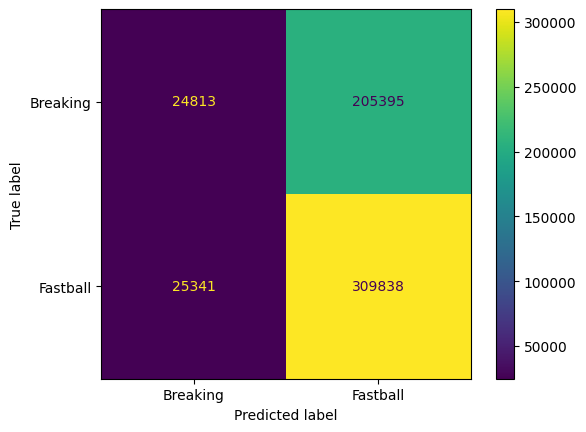

In [27]:
#model performance metrics
print('AUC: ' + str(metrics.roc_auc_score(y_score=probabilities[:,1], y_true=test[response])))
print('Log Loss: ' + str(metrics.log_loss(y_pred=probabilities[:,1], y_true=test[response])))
print('Accuracy Score: ' + str(metrics.accuracy_score(test[response], predictions)))
print('Null Score: ' + str(max(test[response].is_fastball.mean(), 1 - test[response].is_fastball.mean())))
metrics.ConfusionMatrixDisplay(confusion_matrix=metrics.confusion_matrix(test[response], predictions), display_labels=['Breaking', 'Fastball']).plot()
plt.show()

In [28]:
confusion = metrics.confusion_matrix(test[response], predictions)
true_pos = confusion[1, 1]
true_neg = confusion[0, 0]
false_pos = confusion[0, 1]
false_neg = confusion[1, 0]

print('Accuracy of CM: ' + str((true_pos+true_neg)/(true_pos+true_neg+false_pos+false_neg)))
print('False Negative Rate of CM: ' + str(false_neg/(false_neg+true_pos)))
print('False Positive Rate of CM: ' + str(false_pos/(false_pos+true_neg)))


Accuracy of CM: 0.5918972314538538
False Negative Rate of CM: 0.07560437855593578
False Positive Rate of CM: 0.8922148665554629


The histogram shows that the model is not very confident in making fastball predictions. There are circumstances where it is very confident, such as a 3-0 count where the pitcher usually throws a fastball to get the batter to swing and keep the at-bat going. Outside of those few circumstances, most of the probabilities around around 45-75% of pitches predicted to be a fastball.

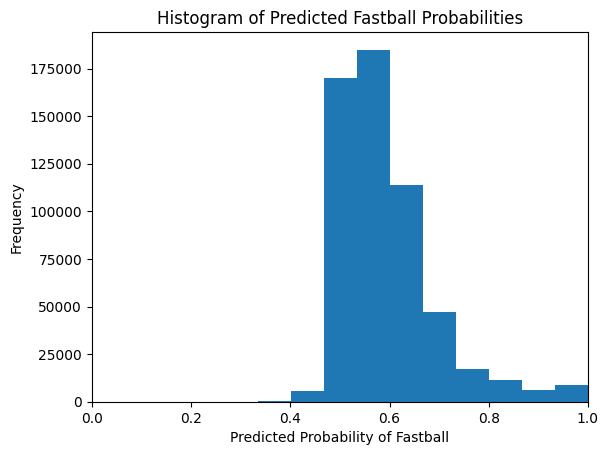

In [29]:
plt.hist(probabilities[:,1], bins=10)
plt.xlim(0,1)
plt.title('Histogram of Predicted Fastball Probabilities')
plt.xlabel('Predicted Probability of Fastball')
plt.ylabel('Frequency')
plt.show()

The ROC curve does not show a lot of certainty between the 2 types of pitches' certainty, as the curve is trending towards a linear line. As a result, this model needs some work and is most likely underfit. 

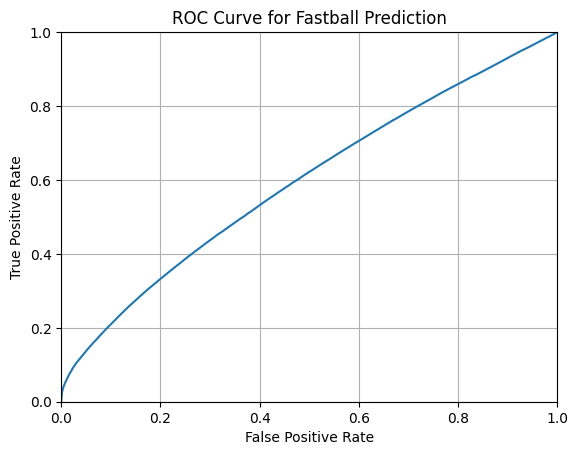

In [30]:
fpr, tpr, thresholds = metrics.roc_curve(test[response], probabilities[:,1])
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC Curve for Fastball Prediction')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)
plt.show()

The best way for Bob and the model to improve is to add more features.  This could most likely be achieved by figuring out more environmental variables, such as number of pitches in the at-bat and foul balls hit during the at-bat. Another way to improve the model could be looking at more seasons than just the 2022 season, possibly incorporating data from the 2010-2021 seasons or including them all. However, the hardware might not be able to include all that data, especially if just one season have over 750,000 data points. 